In [1]:
%matplotlib inline
import sys
root_path = '../../'
sys.path.append(root_path) # go to parent dir

from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
np.random.seed(2021)

### Setup for X and Y 

First, we'll setup our data $(X,Y)$. Note that points $X \in \mathbb{R}^d$ and $Y \in \mathbb{R}$. The linear relationship is 

$$Y = \beta^TX.$$

We generate $n$ such samples. Typically in (fixed-design) linear regression, we get to observe

$$Y' = \beta^TX + \varepsilon,$$

where $\varepsilon \sim \mathcal{N}(0,\sigma I)$. That is, the observations are noisy. However, we don't even access $Y$---only the LFs, so we don't need this. The noise, for us, is in the LFs.

In [2]:
def generate_synthetic_xy(n=1000, d=10):
    '''Generate n (X,Y) points, with X in R^d'''
    # X generation:
    X_mu, X_sigma = np.zeros(d), np.diag(np.random.rand(d))
    X_var = multivariate_normal(mean=X_mu, cov=X_sigma)
    X_samples = X_var.rvs(n)

    # Y generation:
    beta = np.ones(d)
    Y_samples = X_samples @ beta
    
    # Y variance:
    Y_var = np.inner(beta, np.diag(X_sigma))
    return X_samples, Y_samples, Y_var

### Setup for Labeling Functions

We're going to assume a normal relationship between $\Lambda \in \mathbb{R}^m$ and $Y \in \mathbb{R}$. That is,

$$ (\Lambda, Y) \sim \mathcal{N}(0, \Sigma).$$

Note that this implies that the marginal $Y$ is also normal. This shows a dual coupling for $Y$: with $X$ and $\Lambda$. Certainly, if $X$ is also normal, then $\beta^TX$ is normal and we're consistent in terms of distribution. The only other thing we need to keep the coupling consistent is that the variance of $Y$ is the same in the coupled distributions. This is only important for modeling + data generation.

To generate the LFs, we get $X$, generate $Y$, and then use the conditional distribution (also normal!) $\Lambda |Y$ to generate samples of $\Lambda$. Specifically,

$$ \Lambda | Y \sim \mathcal{N}(\bar{\mu}, \bar{\Sigma}),$$

where $\bar{\mu} = \Sigma_{\Lambda Y} \Sigma_{Y}^{-1} y$ and $\bar{\Sigma} = \Sigma_\Lambda - \Sigma_{\Lambda Y} \Sigma_Y^{-1} \Sigma_{Y \Lambda}$. 


In [3]:
def generate_lfs(m, n, Y, Y_var):
    '''Generate m labeling functions for Y '''
    # K is the inverse covariance matrix for the LFs (precision matrix)
    diag_fact, K_fact = 5.0, -3.0 # Some constants to build K
    K = np.zeros([m+1, m+1])
    K[:,m], K[m,:] = np.ones([m+1])*K_fact, np.ones([m+1])*K_fact
    K[m,m] = 0.0
    K += np.eye(m+1) * diag_fact #+ np.random.rand(m+1) * 0.1
    
    # the one trick is that we need Y to be the same as Y_var for the coupling
    # just modify by alpha*e_me_m^T, compute it with Sherman Morrison
    Sigma_temp = np.linalg.inv(K)
    Y_var_temp = Sigma_temp[m,m]
    un    = np.zeros(m+1)
    un[m] = 1.0
    unv   =  np.expand_dims(un, axis=0)
    ent   = Sigma_temp @ np.outer(un,un) @ Sigma_temp
    alpha = (Y_var_temp - Y_var) / (ent[m,m] + (Y_var - Y_var_temp) * unv @ Sigma_temp @ np.transpose(unv))
    Sigma = np.linalg.inv(K + alpha * np.outer(un,un))

    # Generate the LFs.
    # NB: conditional distribution LF | Y ~ N(mu, Sigma)
    Sig_bar = Sigma[:m, :m] - 1.0 / Sigma[m,m] * np.outer(Sigma[m, :m], Sigma[m, :m]) 
    Lambda_var = multivariate_normal(mean=np.zeros(m), cov=Sig_bar)
    L = Lambda_var.rvs(n)
    means = 1.0 / Sigma[m,m] * np.expand_dims(Sigma[:m, m], axis=1) @ np.expand_dims(Y, axis=0)
    L += np.transpose(means)
    
    return L, Sigma

### Label Model For Regression

We're going to do a quick triplet method. The only difference from the normal case we do is that we need to modify the usual triplet equation to account for the variance of $Y$. The system of equations is
\begin{align*}
 \mathbb{E}[\lambda_i \lambda_j] =  \frac{\mathbb{E}[\lambda_i Y]  \mathbb{E}[\lambda_j Y]}{ \mathbb{E}[Y^2]} \\
  \mathbb{E}[\lambda_i \lambda_k] =  \frac{\mathbb{E}[\lambda_i Y]  \mathbb{E}[\lambda_k Y]}{ \mathbb{E}[Y^2]} \\
 \mathbb{E}[\lambda_j \lambda_k] =  \frac{\mathbb{E}[\lambda_j Y]  \mathbb{E}[\lambda_k Y]}{ \mathbb{E}[Y^2]}.
\end{align*}
and the solution,
\begin{align*}
\tilde{\mathbb{E}}[\lambda_i Y] = \left[\frac{\mathbb{E}[\lambda_i \lambda_j] \mathbb{E}[\lambda_i \lambda_k] \mathbb{E}[Y^2]}{\mathbb{E}[\lambda_j \lambda_k]}\right]^{\frac{1}{2}}.
\end{align*}

This covers the LM learning (fit method below). Inference, for Gaussians is super simple (note, no complex junction tree type of thing). This is the mean of a conditional (scalar). It is given by
\begin{align*}
\tilde{Y}(a) := \mathbb{E}[Y | \Lambda = a] = \tilde{\Sigma}_{\Lambda Y}^T \Sigma_{\Lambda}^{-1}a.
\end{align*}
Here,  $\tilde{\Sigma}_{\Lambda Y}$ is the vector we estimated in the parameter estimation step.




In [4]:
class LabelModel():
    def __init__(self, use_triplets=True):
        self.use_triplets = use_triplets # only choice right now
        
    def fit(self, L_train, var_Y):
        self.n, self.m = L_train.shape
        self.O = np.transpose(L_train) @ L_train / self.n
        self.Sigma_hat = np.zeros([m+1, m+1])
        self.Sigma_hat[:m, :m] = self.O
        
        for i in range(m):
            idxes = set(range(m))
            idxes.remove(i)
            # triplet is now i,j,k
            [j,k] = random.sample(idxes, 2)
            # solve from triplet using conditional independence
            acc = np.sqrt( self.O[i,j] * self.O[i,k] * var_Y / self.O[j,k])
            self.Sigma_hat[i,m] = acc
            self.Sigma_hat[m,i] = acc
            
        # we filled in all but the right-bottom corner, add it in
        self.Sigma_hat[m,m] = var_Y
        return
            
    def inference(self, L):
        self.Y_hat = np.zeros(self.n)
        for i in range(self.n):
            self.Y_hat[i] = np.expand_dims(self.Sigma_hat[m,:m], axis=0) \
                            @ np.linalg.inv(self.Sigma_hat[:m,:m]) \
                            @ np.expand_dims(L[i, :self.m], axis=1)
        return
    
    def score(self, Y_samples, metric="mse"):
        err = 0
        for i in range(self.n):
            err += (Y_samples[i] - self.Y_hat[i])**2
        return err / self.n
        

In [5]:
def get_mse(Y_hat, Y_samples):
    err = 0
    n = len(Y_samples)
    for i in range(n):
        err += (Y_samples[i] - Y_hat[i])**2
    return err / n

Let's run it! Simple experiment with varying numbers of samples

In [6]:
# Simple experiment in terms of samples:
# param_err, mu_err, score = np.zeros(5), np.zeros(5), np.zeros(5)

max_iter = 10
param_err, mu_err, score = {}, {}, {}
param_err_bl, mu_err_bl, score_bl = {}, {}, {}

# for n_pow in range(5):
for n_pow in range(1, 6):
    # sample generation
    d,n,m = 5, 10**(1+n_pow), 8
    param_err[n_pow], mu_err[n_pow], score[n_pow] = [], [], []
    param_err_bl[n_pow], mu_err_bl[n_pow], score_bl[n_pow] = [], [], []
    for _ in range(max_iter):
        X, Y, Y_var  = generate_synthetic_xy(n, d)
        L, true_Sigma = generate_lfs(m, n, Y, Y_var)
        
        
        # learn label model and predict
        lm = LabelModel()
        lm.fit(L, Y_var)
        Sigma_hat = lm.Sigma_hat
        param_err[n_pow].append(np.linalg.norm(Sigma_hat - true_Sigma) / (m+1)**2)
        mu_err[n_pow].append(np.linalg.norm(Sigma_hat[:m,m] - true_Sigma[:m,m]) / m)
        lm.inference(L)
        score[n_pow].append(lm.score(Y))
        
        Y_hat_bl = L.mean(axis=1)
        Sigma_hat_bl = np.cov(np.transpose(np.hstack((L, Y.reshape(-1, 1)))))
        param_err_bl[n_pow].append(np.linalg.norm(Sigma_hat_bl - true_Sigma) / (m+1)**2)
        mu_err_bl[n_pow].append(np.linalg.norm(Sigma_hat_bl[:m,m] - true_Sigma[:m,m]) / m)
        score_bl[n_pow].append(get_mse(Y_hat_bl, Y))



In [7]:
# True parameters
df_bl = pd.DataFrame()
for n_pow in range(1, 6):
    for pe, me, s in zip(param_err_bl[n_pow], mu_err_bl[n_pow], score_bl[n_pow]):
        df_bl = df_bl.append({
            'n_pow': n_pow,
            'param_err': pe,
            'mu_err': me,
            'score': s
        }, ignore_index=True)
df_bl_mean = df_bl.groupby('n_pow').mean().reset_index()
df_bl_std = df_bl.groupby('n_pow').std().reset_index()
df_bl = df_bl_mean.merge(df_bl_std, on='n_pow', how='left', suffixes=('_mean', '_std'))

df_bl['param_err_ub'] = df_bl['param_err_mean'] + df_bl['param_err_std'] 
df_bl['mu_err_ub'] = df_bl['mu_err_mean'] + df_bl['mu_err_std']
df_bl['score_ub'] = df_bl['score_mean'] + df_bl['score_std']

df_bl['param_err_lb'] = df_bl['param_err_mean'] - df_bl['param_err_std'] 
df_bl['mu_err_lb'] = df_bl['mu_err_mean'] - df_bl['mu_err_std']
df_bl['score_lb'] = df_bl['score_mean'] - df_bl['score_std']
df_bl

,n_pow,mu_err_mean,param_err_mean,score_mean,mu_err_std,param_err_std,score_std,param_err_ub,mu_err_ub,score_ub,param_err_lb,mu_err_lb,score_lb
0,1.0,0.075038,0.017501,0.454881,0.059775,0.012985,0.134147,0.030486,0.134813,0.589028,0.004517,0.015262,0.320734
1,2.0,0.024904,0.006050,0.465936,0.013172,0.003012,0.109673,0.009061,0.038077,0.575608,0.003038,0.011732,0.356263
2,3.0,0.008497,0.001997,0.401752,0.007601,0.001708,0.148664,0.003706,0.016097,0.550416,0.000289,0.000896,0.253088
3,4.0,0.001794,0.000433,0.376230,0.001074,0.000226,0.090317,0.000659,0.002868,0.466547,0.000207,0.000721,0.285912
4,5.0,0.000805,0.000189,0.405431,0.000769,0.000168,0.091476,0.000357,0.001575,0.496908,0.000021,0.000036,0.313955


<ipython-input-9-08ed9d41e9b1>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.loglog([10**(i+1) for i in range(1, 6)], df['mu_err_mean'], color='g', marker='v', markerSize=9)
<ipython-input-9-08ed9d41e9b1>:43: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.loglog([10**(i+1) for i in range(1, 6)], df['param_err_mean'], color='g', marker='v', markerSize=9)
<ipython-input-9-08ed9d41e9b1>:50: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax3.loglog([10**(i+1) for i in range(1, 6)], df_bl['score_mean'], label='Baseline', marker='o', markerSize=9)
<ipython-input-9-08ed9d41e9b1>:52: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  a

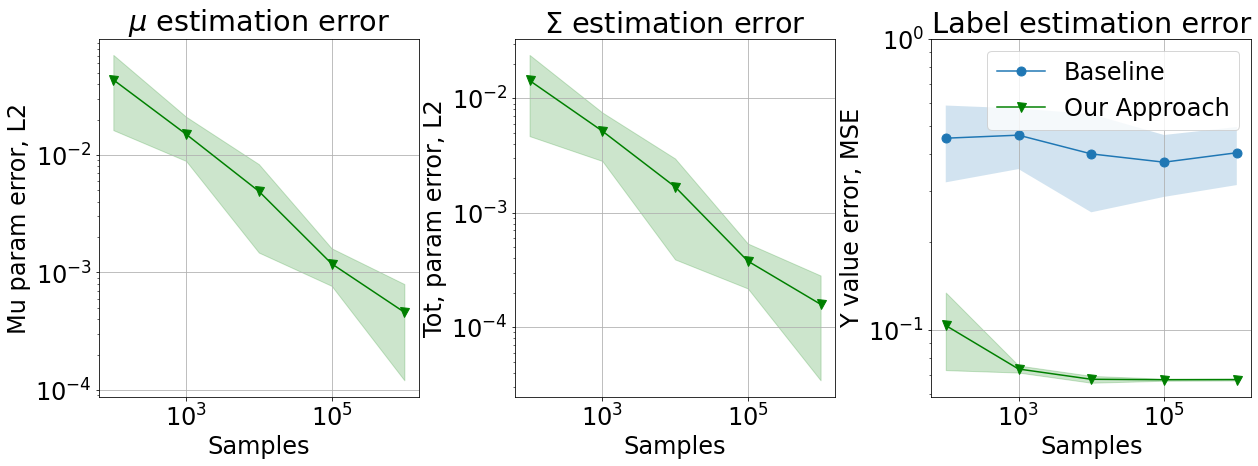

In [9]:
import os
# weak supervision

param_err_mean, mu_err_mean, score_mean = {}, {}, {}
param_err_std, mu_err_std, score_std = {}, {}, {}
for n_pow in param_err:
    param_err_mean[n_pow] = np.mean(param_err[n_pow])
    mu_err_mean[n_pow] = np.mean(mu_err[n_pow])
    score_mean[n_pow] = np.mean(score[n_pow])
    
    param_err_std[n_pow] = np.std(param_err[n_pow])
    mu_err_std[n_pow] = np.std(mu_err[n_pow])
    score_std[n_pow] = np.std(score[n_pow])
    
df = pd.DataFrame()
df['param_err_mean'] = pd.Series(param_err_mean)
df['mu_err_mean'] = pd.Series(mu_err_mean)
df['score_mean'] = pd.Series(score_mean)

df['param_err_std'] = pd.Series(param_err_std)
df['mu_err_std'] = pd.Series(mu_err_std)
df['score_std'] = pd.Series(score_std)

df['param_err_ub'] = df['param_err_mean'] + df['param_err_std'] 
df['mu_err_ub'] = df['mu_err_mean'] + df['mu_err_std']
df['score_ub'] = df['score_mean'] + df['score_std']

df['param_err_lb'] = df['param_err_mean'] - df['param_err_std'] 
df['mu_err_lb'] = df['mu_err_mean'] - df['mu_err_std']
df['score_lb'] = df['score_mean'] - df['score_std']

plt.rcParams['font.size'] = '24'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
legend_fontsize=24

ax1.loglog([10**(i+1) for i in range(1, 6)], df['mu_err_mean'], color='g', marker='v', markerSize=9)
ax1.fill_between([10**(i+1) for i in range(1, 6)], df['mu_err_lb'], df['mu_err_ub'],  color='g', alpha=0.2)
ax1.set(ylabel='Mu param error, L2')
ax1.set(xlabel='Samples')
ax1.grid()
ax1.set_title("$\mu$ estimation error")

ax2.loglog([10**(i+1) for i in range(1, 6)], df['param_err_mean'], color='g', marker='v', markerSize=9)
ax2.fill_between([10**(i+1) for i in range(1, 6)], df['param_err_lb'], df['param_err_ub'],  color='g', alpha=0.2)
ax2.set(ylabel='Tot, param error, L2')
ax2.set(xlabel='Samples')
ax2.grid()
ax2.set_title("$\Sigma$ estimation error")

ax3.loglog([10**(i+1) for i in range(1, 6)], df_bl['score_mean'], label='Baseline', marker='o', markerSize=9)
ax3.fill_between([10**(i+1) for i in range(1, 6)], df_bl['score_lb'], df_bl['score_ub'], alpha=0.2)
ax3.loglog([10**(i+1) for i in range(1, 6)], df['score_mean'], label='Our Approach', color='g', marker='v', markerSize=9)
ax3.fill_between([10**(i+1) for i in range(1, 6)], df['score_lb'], df['score_ub'], color='g', alpha=0.2)
ax3.set(ylabel='Y value error, MSE')
ax3.set(xlabel='Samples')
ax3.grid()
ax3.legend(fontsize=legend_fontsize)
ax3.set_yticks([0.1, 1])
ax3.set_title("Label estimation error")

plt.tight_layout()
fig.subplots_adjust(wspace=.3)
df_samples = df

In [10]:
# Simple experiment in terms of samples:
# param_err, mu_err, score = np.zeros(5), np.zeros(5), np.zeros(5)

max_iter = 10
param_err, mu_err, score = {}, {}, {}
param_err_bl, mu_err_bl, score_bl = {}, {}, {}
for m_pow in range(5):
    # sample generation
    d,n,m = 5, 10000, 2**(2+m_pow)
    param_err[m_pow], mu_err[m_pow], score[m_pow] = [], [], []
    param_err_bl[m_pow], mu_err_bl[m_pow], score_bl[m_pow] = [], [], []
    
    for _ in range(max_iter):
        X, Y, Y_var  = generate_synthetic_xy(n, d)
        L, true_Sigma = generate_lfs(m, n, Y, Y_var)

        # to debug the precision matrix:
        #print("K = \n", np.linalg.inv(true_Sigma))

        # learn label model and predict
        lm = LabelModel()
        lm.fit(L, Y_var)
        Sigma_hat = lm.Sigma_hat
        param_err[m_pow].append(np.linalg.norm(Sigma_hat - true_Sigma) / (m+1)**2)
        mu_err[m_pow].append(np.linalg.norm(Sigma_hat[:m,m] - true_Sigma[:m,m]) / m)
        lm.inference(L)
        score[m_pow].append(lm.score(Y))
        
        Y_hat_bl = L.mean(axis=1)
        Sigma_hat_bl = np.cov(np.transpose(np.hstack((L, Y.reshape(-1, 1)))))
        param_err_bl[m_pow].append(np.linalg.norm(Sigma_hat_bl - true_Sigma) / (m+1)**2)
        mu_err_bl[m_pow].append(np.linalg.norm(Sigma_hat_bl[:m,m] - true_Sigma[:m,m]) / m)
        score_bl[m_pow].append(get_mse(Y_hat_bl, Y))



In [11]:
# True parameters
df_bl = pd.DataFrame()
for m_pow in range(5):
    for pe, me, s in zip(param_err_bl[m_pow], mu_err_bl[m_pow], score_bl[m_pow]):
        df_bl = df_bl.append({
            'm_pow': m_pow,
            'param_err': pe,
            'mu_err': me,
            'score': s
        }, ignore_index=True)
df_bl_mean = df_bl.groupby('m_pow').mean().reset_index()
df_bl_std = df_bl.groupby('m_pow').std().reset_index()
df_bl = df_bl_mean.merge(df_bl_std, on='m_pow', how='left', suffixes=('_mean', '_std'))

df_bl['param_err_ub'] = df_bl['param_err_mean'] + df_bl['param_err_std'] 
df_bl['mu_err_ub'] = df_bl['mu_err_mean'] + df_bl['mu_err_std']
df_bl['score_ub'] = df_bl['score_mean'] + df_bl['score_std']

df_bl['param_err_lb'] = df_bl['param_err_mean'] - df_bl['param_err_std'] 
df_bl['mu_err_lb'] = df_bl['mu_err_mean'] - df_bl['mu_err_std']
df_bl['score_lb'] = df_bl['score_mean'] - df_bl['score_std']
df_bl

,m_pow,mu_err_mean,param_err_mean,score_mean,mu_err_std,param_err_std,score_std,param_err_ub,mu_err_ub,score_ub,param_err_lb,mu_err_lb,score_lb
0,0.0,0.011190,0.003621,0.427896,0.006580,0.002102,0.114797,0.005723,0.017770,0.542693,0.001518,0.004610,0.313098
1,1.0,0.007561,0.001799,0.387538,0.005257,0.001171,0.139873,0.002970,0.012818,0.527412,0.000628,0.002304,0.247665
2,2.0,0.005215,0.000888,0.451647,0.002265,0.000332,0.111160,0.001220,0.007480,0.562806,0.000557,0.002950,0.340487
3,3.0,0.002855,0.000352,0.398059,0.002711,0.000281,0.143530,0.000634,0.005566,0.541589,0.000071,0.000144,0.254529
4,4.0,0.002721,0.000224,0.379466,0.002798,0.000206,0.106494,0.000430,0.005519,0.485960,0.000018,-0.000077,0.272971


<ipython-input-13-d314e1987276>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.loglog([2**(i+2) for i in range(5)], df['mu_err_mean'], marker='v', color='g', markerSize=9, base=2)
<ipython-input-13-d314e1987276>:43: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.loglog([2**(i+2) for i in range(5)], df['param_err_mean'], marker='v', color='g', markerSize=9, base=2)
<ipython-input-13-d314e1987276>:50: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax3.loglog([2**(i+2) for i in range(5)], df_bl['score_mean'], label='Baseline',  marker='o', markerSize=9, base=2)
<ipython-input-13-d314e1987276>:52: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor r

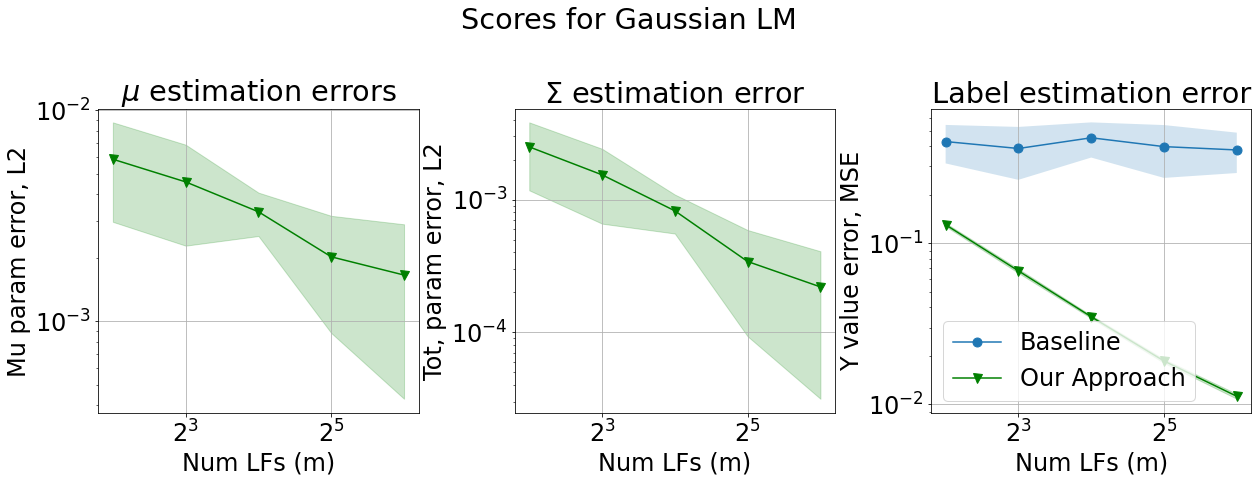

In [13]:
plt.rcParams['font.size'] = '24'
param_err_mean, mu_err_mean, score_mean = {}, {}, {}
param_err_std, mu_err_std, score_std = {}, {}, {}
for m_pow in param_err:
    param_err_mean[m_pow] = np.mean(param_err[m_pow])
    mu_err_mean[m_pow] = np.mean(mu_err[m_pow])
    score_mean[m_pow] = np.mean(score[m_pow])
    
    param_err_std[m_pow] = np.std(param_err[m_pow])
    mu_err_std[m_pow] = np.std(mu_err[m_pow])
    score_std[m_pow] = np.std(score[m_pow])
    
df = pd.DataFrame()
df['param_err_mean'] = pd.Series(param_err_mean)
df['mu_err_mean'] = pd.Series(mu_err_mean)
df['score_mean'] = pd.Series(score_mean)

df['param_err_std'] = pd.Series(param_err_std)
df['mu_err_std'] = pd.Series(mu_err_std)
df['score_std'] = pd.Series(score_std)

df['param_err_ub'] = df['param_err_mean'] + df['param_err_std'] 
df['mu_err_ub'] = df['mu_err_mean'] + df['mu_err_std']
df['score_ub'] = df['score_mean'] + df['score_std']

df['param_err_lb'] = df['param_err_mean'] - df['param_err_std'] 
df['mu_err_lb'] = df['mu_err_mean'] - df['mu_err_std']
df['score_lb'] = df['score_mean'] - df['score_std']

df.head()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
legend_fontsize=24

fig.suptitle('Scores for Gaussian LM')
ax1.loglog([2**(i+2) for i in range(5)], df['mu_err_mean'], marker='v', color='g', markerSize=9, base=2)
ax1.fill_between([2**(i+2) for i in range(5)], df['mu_err_lb'], df['mu_err_ub'],  color='g', alpha=0.2)
ax1.set(ylabel='Mu param error, L2')
ax1.set(xlabel='Num LFs (m)')
ax1.set_title("$\mu$ estimation errors")
ax1.grid()

ax2.loglog([2**(i+2) for i in range(5)], df['param_err_mean'], marker='v', color='g', markerSize=9, base=2)
ax2.fill_between([2**(i+2) for i in range(5)], df['param_err_lb'], df['param_err_ub'],  color='g', alpha=0.2)
ax2.set(ylabel='Tot, param error, L2')
ax2.set(xlabel='Num LFs (m)')
ax2.grid()
ax2.set_title("$\Sigma$ estimation error")

ax3.loglog([2**(i+2) for i in range(5)], df_bl['score_mean'], label='Baseline',  marker='o', markerSize=9, base=2)
ax3.fill_between([2**(i+2) for i in range(5)], df_bl['score_lb'], df_bl['score_ub'], alpha=0.2)
ax3.loglog([2**(i+2) for i in range(5)], df['score_mean'], label='Our Approach',  marker='v', color='g', markerSize=9,  base=2)
ax3.fill_between([2**(i+2) for i in range(5)], df['score_lb'], df['score_ub'],  color='g', alpha=0.2)
ax3.set(ylabel='Y value error, MSE')
ax3.set(xlabel='Num LFs (m)')
ax3.grid()
ax3.legend(fontsize=legend_fontsize)
ax3.set_title("Label estimation error")
ax1.set_yscale("log", base=10)
ax2.set_yscale("log", base=10)
ax3.set_yscale("log", base=10)
plt.tight_layout()
fig.subplots_adjust(wspace=.3)